title: Statistics and Insights Usage Research 
<br>
date: 2021-09-14
<br>
region: US
<br>
author: Henry Xu
<br>
tags: statistics, insights, feature, product, discovery, usage, entry.
<br>
summary: 
    This research looks at the statistics and insights usage in the US market at a high level. Questions answered are: 
> - Where do users enter the feature?
> - How many / what percentage of MAU's use statistics and insights feature throughout 2021?
> - How is the retention for statistics and insights?

## Statistics and Insights Usage Research

Findings:

> - Most statistics and insights users enter through the quick action button on the home feed screen. Around 60% until June, and rises to 70% as number of stats users dropped at the end of June.
> - Membership Details is the least popular entry point, around 15% until June, and dropped to 10% at the end of June.
> - There is a revamp in tracking the landing screen of the feature at the start of February, and the tracking for all stats related events paused for 2 weeks. Therefore all analysis is based on March value and beyond.
> - Pecentage of statistics and insights users out of MAU's has been dropping from 7% in March to 4% in August.
> - First month retention has been dropping from 27% in March to 15% in June, rising to 19% in July as we closed accounts with KYC issues in July.
> - Compared to EU whose monthly percentage of MAU's who use stats feature fluctuates around 16% to 19.7%, the US performs slightly worse for this metric. However the retention drops faster than EU.
> - Retention is dropping gradually for each cohort, as expected. However, faster decline of retention is observed for later cohorts.The same phenomenon can be observed in EU. Possible reasons include:
>> - Seasonality
>> - Different user behavior by platform, age, MAU statuses,etc.
<br>

Further investigation will be conducted separately.

In [1]:
# pip install matplotlib

In [2]:
# pip install seaborn

In [3]:
## Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [4]:
## Import data
## Entry point for stats users


from datalib import database
from utils import setup

db = database.Database("redshiftreader", setup.config_file, setup.vault_section)
db.create_engine(sslmode="require")


with db.engine.begin() as conn:
    stats_user_entry = db.df_from_sql(
        """
        select
           to_char(date_trunc('week', kec.collector_tstamp),'yyyy-mm-dd') as week_starting,
            se_action,
            COUNT(distinct kec.user_id) as user_cnt
        from etl_reporting.ksp_event_core kec 
        inner join etl_reporting.ksp_event_types ket 
            on kec.event_type = ket.event_type 
        inner join etl_reporting.ksp_ip_geo kig 
            on kec.event_id = kig.event_id 
        where 1 = 1
            and kig.country = 'US'
            and kec.collector_tstamp >= '2021-01-01'
            and date_trunc('week', kec.collector_tstamp) < date_trunc('week', current_date)
            and (
                ket.se_action = 'feed.quickactions.statistics.clicked' -- entry point: quick_actions
                or 
                (ket.se_action = 'membership.benefits-list.click' and kec.se_label = 'benefit_expand_SPENDING_STATISTICS') -- entry point: membership
                or 
                ket.se_action = 'statistics_viewed'
                )
        group by 1,2
        order by 1,2
        """,
        connection=conn,
    )

In [5]:
## Import data
## Stats user number vs MAU by month

with db.engine.begin() as conn:
    stats_user_by_mau = db.df_from_sql(
        """
        with d as(
            select 
                date,
                month_end
            from dbt.dim_dates
            where date between '2021-01-01' and current_date
        ),
        statistics as (
            select 
                kec.event_id,
                du.user_id,
                kec.se_label,
                ket.se_category,
                ket.se_action,
                kec.collector_tstamp,
                kig.country,
                case 
                    when kec.platform = -1 then 'Web'
                    when kec.platform = 0 then 'Other'
                    when kec.platform = 1 then 'Android'
                    else 'IOS'
                end as platform
            from etl_reporting.ksp_event_core kec 
            inner join etl_reporting.ksp_event_types ket 
                on kec.event_type = ket.event_type 
            inner join etl_reporting.ksp_ip_geo kig 
                on kec.event_id = kig.event_id 
            inner join dbt.dim_users du 
                on du.shadow_user_id = kec.user_id 
            where 1 = 1
                and kig.country = 'US'
                and kec.collector_tstamp >= '2021-01-01'
                and (
                       se_action in (
                        'statistics.toggle_month',
                        'statistics.directions_switched',
                        'statistics.toggle_income',
                        'statistics.category_list',
                        'statistics_overview',
                        'statistics.category_pie',
                        'feed.quickactions.statistics.clicked', -- entry point to statistics
                        'statistics_viewed', -- entry point to statistics
                        'statistics.category_selected'
                        )
                    or
                    se_category in (
                        'statistics'
                        )
                    )
                    or (
                        se_action = 'membership.benefits-list.click'
                        and se_label = 'benefit_action_SPENDING_STATISTICS'
                    )
        )
        select 
            to_char(d.month_end, 'yyyy-mm'),
            count(distinct fuat.user_id) as mau,
            count(distinct s.user_id) as stats_user,
            100 * stats_user::float / mau::float as stats_user_by_mau
        from dbt.f_user_activity_txn as fuat
        inner join d 
            on d.date between fuat.activity_start and fuat.activity_end
            and activity_type = '1_tx_35'
        left join statistics as s
            on s.user_id = fuat.user_id
            and d.date = date_trunc('day', s.collector_tstamp)
        group by 1
        order by 1 asc
        """,
        connection=conn,
    )

In [6]:
## Import data mau table

with db.engine.begin() as conn:
    mau_df = db.df_from_sql(
        """
        select 
            d.date,
            to_char(d.week_end, 'yyyy-mm-dd') as week_end,
            to_char(d.month_end, 'yyyy-mm') as month_end,
            fuat.user_id,
            du.shadow_user_id
        from dbt.f_user_activity_txn as fuat
        inner join dbt.dim_dates as d
            on d.date between fuat.activity_start and fuat.activity_end
            and activity_type = '1_tx_35'
            and d.date between '2021-01-01' and current_date
        inner join dbt.dim_users as du
            on du.user_id = fuat.user_id
        """,
        connection=conn,
    )

In [7]:
## Import Data
## Users who have had statistics related events in 2021 in the US

with db.engine.begin() as conn:
    stats = db.df_from_sql(
        """
        select 
            kec.event_id,
            kec.user_id,
            kec.se_label,
            ket.se_category,
            ket.se_action,
            kec.collector_tstamp,
            kig.country,
            case 
                when kec.platform = -1 then 'Web'
                when kec.platform = 0 then 'Other'
                when kec.platform = 1 then 'Android'
                else 'IOS'
            end as platform
        from etl_reporting.ksp_event_core kec 
        inner join etl_reporting.ksp_event_types ket 
            on kec.event_type = ket.event_type 
        inner join etl_reporting.ksp_ip_geo kig 
            on kec.event_id = kig.event_id 
        where 1 = 1
            and kig.country = 'US'
            and kec.collector_tstamp >= '2021-01-01'
            and (
                   se_action in (
                    'statistics.toggle_month',
                    'statistics.directions_switched',
                    'statistics.toggle_income',
                    'statistics.category_list',
                    'statistics_overview',
                    'statistics.category_pie',
                    'feed.quickactions.statistics.clicked', -- entry point to statistics
                    'statistics_viewed', -- entry point to statistics
                    'statistics.category_selected'
                    )
                or
                se_category in (
                    'statistics'
                    )
                )
                or (
                    se_action = 'membership.benefits-list.click'
                    and se_label = 'benefit_action_SPENDING_STATISTICS'
                )
        """,
        connection=conn,
    )

### Entry Point for Statistics and Insights

Define name of entry points

feed_quick_action: statistics quick action button on the feed page
<br>
membership_detail: explore tab -> memebership details -> statistics
<br>
burger_menu: three dots and three line icon next to magnifying glass icon on the feed page
<br>
<br>
 *If a user enters the feature any day of the week, their action is group to the start of the week.

In [8]:
## Define name of entry points

entry = np.empty(len(stats_user_entry["se_action"]), dtype=object)

entry[
    stats_user_entry["se_action"] == "feed.quickactions.statistics.clicked"
] = "feed_quick_action"
entry[
    stats_user_entry["se_action"] == "membership.benefits-list.click"
] = "membership_detail"
entry[stats_user_entry["se_action"] == "statistics_viewed"] = "burger_menu"

stats_user_entry["entry"] = entry

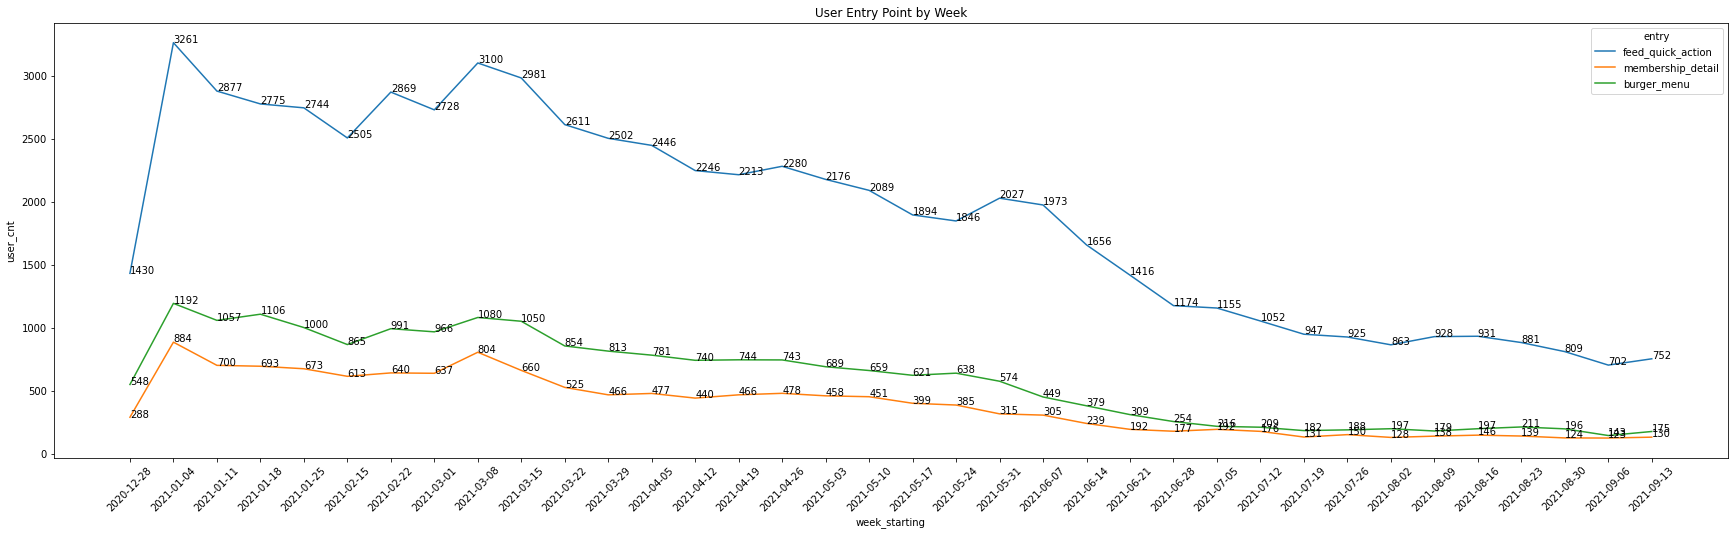

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(30, 8))
# plt.figure(figsize = (30,8))

sns.lineplot(x="week_starting", y="user_cnt", hue="entry", data=stats_user_entry)

for item in stats_user_entry.groupby("entry"):
    # item[1] is a grouped data frame
    for x, y in item[1][["week_starting", "user_cnt"]].values:
        ax.text(x, y, y)

plt.xticks(rotation=45)
plt.title("User Entry Point by Week")
plt.show()

### Statistics and Insights Users vs MAU

#### Statistics and Insights User by Month

*MAU definition here: if a user is MAU during any period of the month, he/she is counted as a MAU in this graph.

In [10]:
## Rename column

stats_user_by_mau.rename(columns={"to_char": "month"}, inplace=True)
stats_user_by_mau = stats_user_by_mau[
    :-1
]  ## remove the most recent month since data collection has not been completed

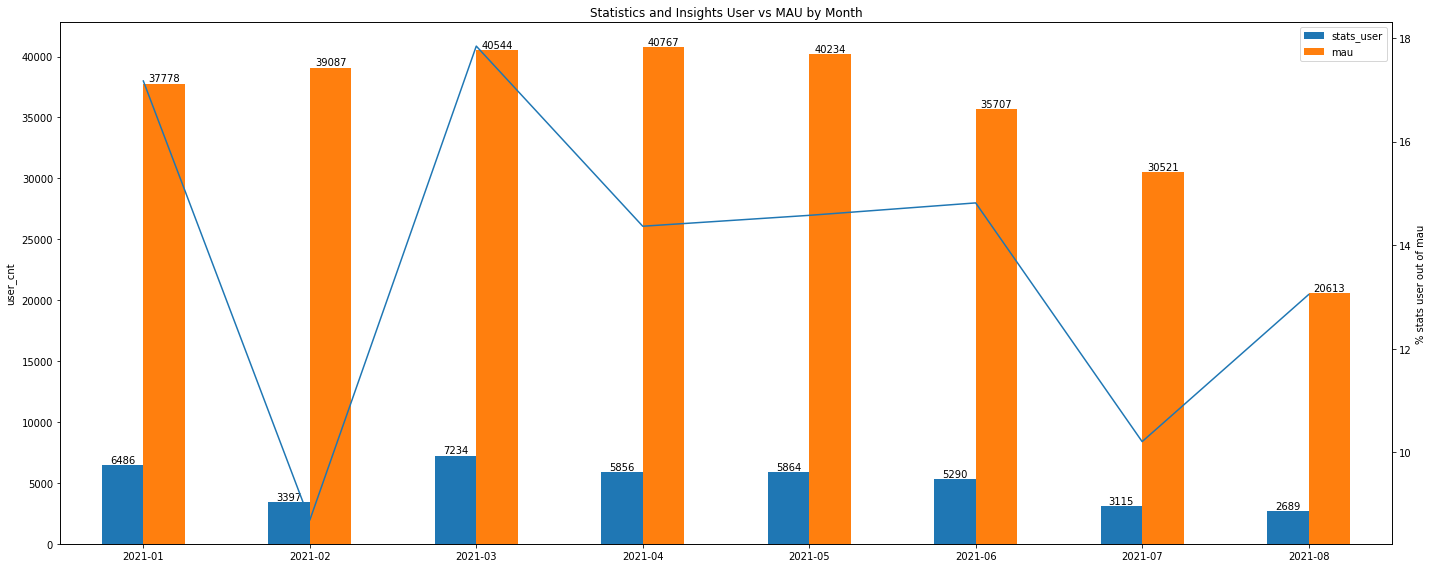

In [11]:
## Plot stats users vs MAU by month

fig, ax = plt.subplots(figsize=(20, 8))
stats_user_by_mau[["stats_user", "mau"]].plot(
    kind="bar",
    figsize=(20, 8),
    ylabel="user_cnt",
    title="Statistics and Insights User vs MAU by Month",
    ax=ax,
)
stats_user_by_mau["stats_user_by_mau"].plot(secondary_y=True)

ax2 = plt.gca()
ax.set_xticklabels(stats_user_by_mau["month"])
ax2.set_ylabel("% stats user out of mau")

for container in ax.containers:
    ax.bar_label(container)


plt.tight_layout()
plt.show()

We observe a big drop in February 2021.
<br>
Investigate this by expanding the time series to check stats user vs mau by week.

#### Statistics and Insights User by Week

*MAU definiton here: If a user is MAU during any period of the week, he/she is counted as MAU in this graph.

In [12]:
## Get the date of collector_tstamp

from datetime import datetime as dt

stats["date"] = stats["collector_tstamp"].dt.date

In [13]:
## merge mau_df and stats to match maus who use stats feature
## left join to keep all maus

m_df = pd.merge(
    mau_df,
    stats,
    how="left",
    left_on=["shadow_user_id", "date"],
    right_on=["user_id", "date"],
)

In [14]:
## count unique stats users
## count mau
## calculate percentage

df1 = m_df.groupby("week_end")["shadow_user_id"].nunique().reset_index()
df2 = m_df.groupby("week_end")["user_id_y"].nunique().reset_index()
stats_user_by_mau_week = pd.merge(df1, df2, on="week_end")

stats_user_by_mau_week.rename(
    columns={"shadow_user_id": "mau", "user_id_y": "stats_user"}, inplace=True
)
stats_user_by_mau_week["stats_user_by_mau"] = (
    round(
        stats_user_by_mau_week["stats_user"] / stats_user_by_mau_week["mau"], ndigits=3
    )
    * 100
)

stats_user_by_mau_week = stats_user_by_mau_week[
    :-1
]  ## removing the most recent week since data collection has not been completed

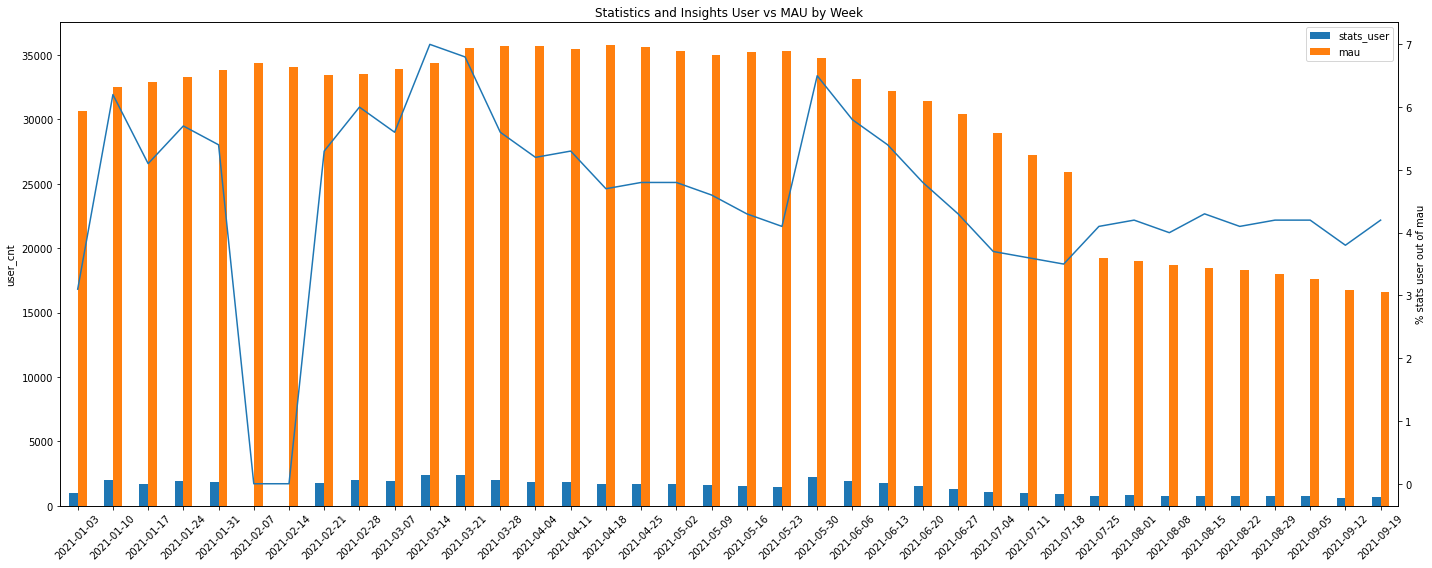

In [15]:
## Plot stats users vs MAU by week

stats_user_by_mau_week[["stats_user", "mau"]].plot(
    kind="bar",
    figsize=(20, 8),
    ylabel="user_cnt",
    title="Statistics and Insights User vs MAU by Week",
)
stats_user_by_mau_week["stats_user_by_mau"].plot(secondary_y=True, rot=45)

ax = plt.gca()
ax.set_xticklabels(stats_user_by_mau_week["week_end"])
ax.set_ylabel("% stats user out of mau")

plt.tight_layout()
plt.show()

Findings:
    Due to statistics and insights revamp in February, we stopped tracking statistics related events for two weeks starting 2021-02-07, which caused the drop in number of stats users in February.

### Statistics and Insights Retention

#### Retention Definition

Since the statistics and insights revamp in February, a new event 'dashboard.viewed' was introduced as the first entry event when user lands on the feature.
<br>
We use this event to defined the cohorts. 
<br>
Retention is defined as a user visitng statistics and insights feature and having any event generated in X month since the first visit.

#### Number of Users Retained Monthly

Because we stopped tracking statistics events for two weeks in February, we should be looking at retention starting from March.
<br>
Otherwise, the loss of data would mess up the calculation.
<br> 
The new se_action = dashboard.viewed is the starting point for any statistics engagement.
<br>
Therefore, we determine a user's cohort by looking at the first time he/she had this action.

In [16]:
## for each stats user, when did they first land on statistics dashboard

stats_db = stats[stats["se_action"] == "dashboard.viewed"]
first_stats_db = stats_db.groupby("user_id")["collector_tstamp"].min().reset_index()
first_stats_db.rename(columns={"collector_tstamp": "first_db_tstamp"}, inplace=True)

In [17]:
## join first_stats_db with stats to append the timestamp of when user first viewed the dashboard
## filter to only valid rows by using collector_tstamp >= first_db_tstamp

merge_df = pd.merge(first_stats_db, stats, on="user_id")
df = merge_df[
    (merge_df["collector_tstamp"] >= merge_df["first_db_tstamp"])
    & (merge_df["first_db_tstamp"].dt.month < dt.now().month)
    & (merge_df["collector_tstamp"].dt.month < dt.now().month)
]

In [18]:
## get cohort of each user
## get the action month: the month user performed a stats action
## get month since first view month

pd.options.mode.chained_assignment = None
df.loc[:, "cohort"] = df.loc[:, "first_db_tstamp"].dt.strftime("%Y-%m")
df.loc[:, "action_month"] = df.loc[:, "collector_tstamp"].dt.month
df["month_passed"] = (
    df.loc[:, "collector_tstamp"].dt.month - df.loc[:, "first_db_tstamp"].dt.month
)

Retention Count Matrix

In [19]:
## create pivot table based on cohort and month_passed

df_group = df.groupby(["cohort", "month_passed"])["user_id"].nunique().reset_index()
retention_cnt_pivot = df_group.pivot_table(
    index="cohort", columns="month_passed", values="user_id", fill_value=0
)
retention_cnt_pivot

month_passed,0,1,2,3,4,5,6
cohort,,,,,,,
2021-02,110,41,31,21,15,4,4
2021-03,9637,2600,1938,1367,764,597,0
2021-04,7982,1810,1069,525,414,0,0
2021-05,6204,1239,509,372,0,0,0
2021-06,3802,608,402,0,0,0,0
2021-07,2086,399,0,0,0,0,0
2021-08,1790,0,0,0,0,0,0


Retention Heatmap

Text(0.5, 1.0, 'Retention User Count Heatmap')

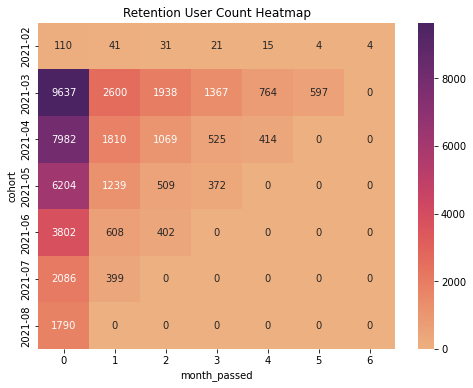

In [20]:
## plot retention count heat map

plt.figure(figsize=(8, 6))
sns.heatmap(retention_cnt_pivot, cmap="flare", annot=True, fmt="d")
plt.title("Retention User Count Heatmap")

#### Percentage of Users Retained Monthly

Retention Percentage Matrix

In [21]:
## calculate cohort size
## divide each month number of users by cohort size

cohort_size = retention_cnt_pivot.iloc[:, 0]
retention_pct_matrix = retention_cnt_pivot.divide(cohort_size, axis=0)
retention_pct_matrix

month_passed,0,1,2,3,4,5,6
cohort,,,,,,,
2021-02,1.0,0.372727,0.281818,0.190909,0.136364,0.036364,0.036364
2021-03,1.0,0.269794,0.201100,0.141849,0.079278,0.061949,0.000000
2021-04,1.0,0.226760,0.133926,0.065773,0.051867,0.000000,0.000000
2021-05,1.0,0.199710,0.082044,0.059961,0.000000,0.000000,0.000000
2021-06,1.0,0.159916,0.105734,0.000000,0.000000,0.000000,0.000000
2021-07,1.0,0.191275,0.000000,0.000000,0.000000,0.000000,0.000000
2021-08,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Retention Percentage Heatmap

Text(0.5, 1.0, 'Retention User Percentage Heatmap')

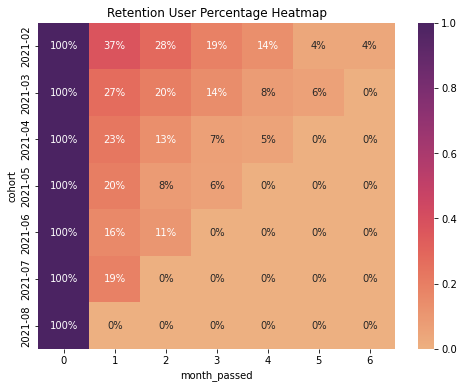

In [22]:
## plot retention percentage heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(retention_pct_matrix, cmap="flare", annot=True, fmt=".0%")
plt.title("Retention User Percentage Heatmap")